In [12]:
from __future__ import division
from math import *
import numpy as np
import sys
import os
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import LogFormatterExponent
from matplotlib.ticker import LogFormatterSciNotation

import pandas as pd
import numpy as np
import matplotlib, os
import matplotlib.pyplot as plt
# Matplotlib configuration
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.style.use('classic')
plt.rcParams['xtick.direction']     = 'in'
plt.rcParams['ytick.direction']     = 'in'
plt.rcParams['xtick.top']           = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.right']         = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import matplotlib.cm as cm

from matplotlib import pyplot
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family' : "sans-serif"})
params= {'text.latex.preamble' : [r'\usepackage{amssymb}']}
pyplot.rcParams.update(params)

from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FuncFormatter
from scipy.interpolate import griddata
from scipy.interpolate import interp1d

import sys
sys.path.append("/Users/oozdal/packages/ma5-histo")
sys.path.append("/Users/oozdal/packages/ma5_expert")

import src.SafReader as sr
from CutFlowReader import Collection 

import scipy.stats
from scipy.spatial import distance

import math

In [13]:
def df(fileLoc):
    data = sr.read(fileLoc=fileLoc)
    floatCols=['binMin', 'binMax', 'value']
    data[floatCols]  = data[floatCols].apply(pd.to_numeric, errors='coerce')
    data["bin"]      = (data.binMin+data.binMax)/2
    data             = data[data.binMax != np.inf]
    data             = data[data.binMin != -1*np.inf]
    data["binlabel"] = (data.binMin+data.binMax)/2
    return data

In [14]:
def unc(observable, Nevt):
    return np.sqrt((1-observable**2)/Nevt)

def sig(O1, O2, Nevt1, Nevt2):
    return abs(O1-O2)/np.sqrt( unc(O2,Nevt2)**2 ) # + O1*unc(O1,Nevt1)**2 )

def jensen_shannon_distance(p, q):
    """
    method to compute the Jenson-Shannon Distance 
    between two probability distributions
    """

    # convert the vectors into numpy arrays in case that they aren't
    p = np.array(p)
    q = np.array(q)

    # calculate m
    m = (p + q) / 2

    # compute Jensen Shannon Divergence
    divergence = (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m)) / 2

    # compute the Jensen Shannon Distance
    distance = np.sqrt(divergence)

    return distance

def KLD(p, q):
    """
    Elementwise function for computing Kullback-Leibler divergence.
    """
    
    # convert the vectors into numpy arrays in case that they aren't
    p = np.array(p)
    q = np.array(q)   

    # compute Kullback-Leibler divergence
    kl_div = scipy.special.kl_div(p, q)

    return kl_div

def sigmoid(x):
    
    x = np.array(x)
    return 1 / (1 + math.exp(-x))

In [15]:
lumi=3000.

# Standard Model 

In [16]:
AFB_data = '/Users/oozdal/projects/SSM_WpZp/AFB_data'

SM = Collection(collection_path= AFB_data+'/SMll_Mll4500and8000/MadAnalysis5job_0/Cutflows',
                    saf_file       = AFB_data+'/SMll_Mll4500and8000/SMll_Mll4500and8000.saf',
                    lumi           = 3000.)
SM_sumw   = SM['Rap_No'][0].sumw
SM_histos = df(AFB_data+'/SMll_Mll4500and8000/MadAnalysis5job_0/Histograms/histos.saf')

In [17]:
SM_df = pd.read_csv('/Users/oozdal/projects/SSM_WpZp/AFB_data/SM.csv', header=0, sep=",")
SM_df.columns = ["Mll", "angle_CM_true", "angle_CM_rec", "cos_angle_CM_star", "Eta_lp", "Eta_lm", "Mll_Boosted", "Eta_Boosted_lp", "Eta_Boosted_lm", "quarkcharge",
"Lepton_Charge","yll_lab", "yll_CM","EvWeight"]

Let's apply some bounds

In [18]:
SM_df = SM_df[ (SM_df["Mll"] >= 5400.)  & (SM_df["Mll"] <= 6600.) ]      # Mll [5-6] TeV
SM_df = SM_df[ (SM_df["Eta_lp"] <= 2.5) & (SM_df["Eta_lm"] <= 2.5) ]     # Eta(lepton) < 2.5
SM_df = SM_df[ (SM_df["Lepton_Charge"] < 0.) ]  # We will compute AFB using negatively charged leptons. Therefore we don't need positive leptons! 

# True AFB Components for the SM

In [19]:
SM_AFB_pos = SM_df[ np.cos(SM_df["angle_CM_true"]) > 0. ]
SM_AFB_neg = SM_df[ np.cos(SM_df["angle_CM_true"]) < 0. ]

BinNumber = 12
BinFirst  = 5400.
BinLast   = 6600.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

#bins = [5400.0, 5900.0, 6000.0, 6100.0, 6600.0] 


TotEvWeight_LepPos_List1 = []
TotEvWeight_LepNeg_List1 = []

TotEvWeight_LepPos_List2 = []
TotEvWeight_LepNeg_List2 = []


i=0
for i in range(len(bins)-1):
    Box_LepPos = SM_AFB_pos[:][ (SM_AFB_pos["Mll"]>bins[i]) & (SM_AFB_pos["Mll"]<bins[i+1]) ]
    TotEvWeight_LepPos = len(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List1.append(TotEvWeight_LepPos)
    TotEvWeight_LepPos = sum(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List2.append(TotEvWeight_LepPos)
       
    Box_LepNeg = SM_AFB_neg[:][ (SM_AFB_neg["Mll"]>bins[i]) & (SM_AFB_neg["Mll"]<bins[i+1]) ]
    TotEvWeight_LepNeg = len(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List1.append(TotEvWeight_LepNeg)
    TotEvWeight_LepNeg = sum(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List2.append(TotEvWeight_LepNeg)       
    
TotEvWeight_LepPos_Arr1 = np.array(TotEvWeight_LepPos_List1)
TotEvWeight_LepNeg_Arr1 = np.array(TotEvWeight_LepNeg_List1)

TotEvWeight_LepPos_Arr2 = np.array(TotEvWeight_LepPos_List2)
TotEvWeight_LepNeg_Arr2 = np.array(TotEvWeight_LepNeg_List2)

AFB_num = TotEvWeight_LepPos_Arr1 - TotEvWeight_LepNeg_Arr1
AFB_den = TotEvWeight_LepPos_Arr1 + TotEvWeight_LepNeg_Arr1

AFB_SM     = AFB_num/np.where(AFB_den==0,1e10,AFB_den)

SM_totsumw = sum(TotEvWeight_LepPos_Arr2)+sum(TotEvWeight_LepNeg_Arr2)

#Number of Events
NumofEvents_LepPos_SM = TotEvWeight_LepPos_Arr2*lumi*SM.xsec*1000/SM_sumw
NumofEvents_LepNeg_SM = TotEvWeight_LepNeg_Arr2*lumi*SM.xsec*1000/SM_sumw

# LRSM

In [20]:
AFB_data = '/Users/oozdal/projects/SSM_WpZp/AFB_data'

LRSM = Collection(collection_path= AFB_data+'/LRSMdilep_LO/MadAnalysis5job_0/Cutflows',
                    saf_file       = AFB_data+'/LRSMdilep_LO/LRSMdilep_LO.saf',
                    lumi           = 3000.)
LRSM_sumw   = LRSM['Rap_No'][0].sumw
LRSM_histos = df(AFB_data+'/LRSMdilep_LO/MadAnalysis5job_0/Histograms/histos.saf')

In [21]:
LRSM_df = pd.read_csv('/Users/oozdal/projects/SSM_WpZp/AFB_data/LRSMdilep_LO.csv', header=0, sep=",")
LRSM_df.columns = ["Mll", "angle_CM_true", "angle_CM_rec", "cos_angle_CM_star", "Eta_lp", "Eta_lm", "Mll_Boosted", "Eta_Boosted_lp", "Eta_Boosted_lm", "quarkcharge",
"Lepton_Charge","yll_lab", "yll_CM","EvWeight"]

Let's apply some bounds

In [22]:
LRSM_df = LRSM_df[ (LRSM_df["Mll"] >= 5400.)  & (LRSM_df["Mll"] <= 6600.) ]      # Mll [5-6] TeV
LRSM_df = LRSM_df[ (LRSM_df["Eta_lp"] <= 2.5) & (LRSM_df["Eta_lm"] <= 2.5) ]     # Eta(lepton) < 2.5
LRSM_df = LRSM_df[ (LRSM_df["Lepton_Charge"] < 0.) ]  # We will compute AFB using negatively charged leptons. Therefore we don't need positive leptons! 

# True AFB Components for LRSM

In [23]:
LRSM_df_AFB_pos = LRSM_df[ np.cos(LRSM_df["angle_CM_true"]) > 0. ]
LRSM_df_AFB_neg = LRSM_df[ np.cos(LRSM_df["angle_CM_true"]) < 0. ]

BinNumber = 12
BinFirst  = 5400.
BinLast   = 6600.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

#bins = [5400.0, 5900.0, 6000.0, 6100.0, 6600.0]   

TotEvWeight_LepPos_List1 = []
TotEvWeight_LepNeg_List1 = []

TotEvWeight_LepPos_List2 = []
TotEvWeight_LepNeg_List2 = []


i=0
for i in range(len(bins)-1):
    Box_LepPos = LRSM_df_AFB_pos[:][ (LRSM_df_AFB_pos["Mll"]>bins[i]) & (LRSM_df_AFB_pos["Mll"]<bins[i+1]) ]
    TotEvWeight_LepPos = len(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List1.append(TotEvWeight_LepPos)
    TotEvWeight_LepPos = sum(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List2.append(TotEvWeight_LepPos)
       
    Box_LepNeg = LRSM_df_AFB_neg[:][ (LRSM_df_AFB_neg["Mll"]>bins[i]) & (LRSM_df_AFB_neg["Mll"]<bins[i+1]) ]
    TotEvWeight_LepNeg = len(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List1.append(TotEvWeight_LepNeg)
    TotEvWeight_LepNeg = sum(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List2.append(TotEvWeight_LepNeg)       
    
TotEvWeight_LepPos_Arr1 = np.array(TotEvWeight_LepPos_List1)
TotEvWeight_LepNeg_Arr1 = np.array(TotEvWeight_LepNeg_List1)

TotEvWeight_LepPos_Arr2 = np.array(TotEvWeight_LepPos_List2)
TotEvWeight_LepNeg_Arr2 = np.array(TotEvWeight_LepNeg_List2)

AFB_num = TotEvWeight_LepPos_Arr1 - TotEvWeight_LepNeg_Arr1
AFB_den = TotEvWeight_LepPos_Arr1 + TotEvWeight_LepNeg_Arr1

AFB_LRSM     = AFB_num/np.where(AFB_den==0,1e10,AFB_den)

LRSM_totsumw = sum(TotEvWeight_LepPos_Arr2)+sum(TotEvWeight_LepNeg_Arr2)

#Number of Events
NumofEvents_LepPos_LRSM = TotEvWeight_LepPos_Arr2*lumi*LRSM.xsec*1000/LRSM_sumw
NumofEvents_LepNeg_LRSM = TotEvWeight_LepNeg_Arr2*lumi*LRSM.xsec*1000/LRSM_sumw

# ALRSM

In [24]:
AFB_data = '/Users/oozdal/projects/SSM_WpZp/AFB_data'

ALRSM = Collection(collection_path = AFB_data+'/ALRSMdilep_LO_Zp6TeV/MadAnalysis5job_0/Cutflows',
                    saf_file         = AFB_data+'/ALRSMdilep_LO_Zp6TeV/ALRSMdilep_LO_Zp6TeV.saf',
                    lumi             = 3000.)
ALRSM_sumw   = ALRSM['Rap_No'][0].sumw
ALRSM_histos = df(AFB_data+'/ALRSMdilep_LO_Zp6TeV/MadAnalysis5job_0/Histograms/histos.saf')

In [25]:
ALRSM_df = pd.read_csv('/Users/oozdal/projects/SSM_WpZp/AFB_data/ALRSMdilep_LO_Zp6TeV.csv', header=0, sep=",")
ALRSM_df.columns = ["Mll", "angle_CM_true", "angle_CM_rec", "cos_angle_CM_star", "Eta_lp", "Eta_lm", "Mll_Boosted", "Eta_Boosted_lp", "Eta_Boosted_lm", "quarkcharge",
"Lepton_Charge","yll_lab", "yll_CM","EvWeight"]

print(min(ALRSM_df["Mll"]))
print(max(ALRSM_df["Mll"]))

5400.0
6599.97


In [26]:
ALRSM_df = ALRSM_df[ (ALRSM_df["Mll"] >= 5400.)  & (ALRSM_df["Mll"] <= 6600.) ]      # Mll [5-6] TeV
ALRSM_df = ALRSM_df[ (ALRSM_df["Eta_lp"] <= 2.5) & (ALRSM_df["Eta_lm"] <= 2.5) ]     # Eta(lepton) < 2.5
ALRSM_df = ALRSM_df[ (ALRSM_df["Lepton_Charge"] < 0.) ]  # We will compute AFB using negatively charged leptons. Therefore we don't need positive leptons! 

# True AFB Components for ALRSM

In [27]:
ALRSM_df_AFB_pos = ALRSM_df[ np.cos(ALRSM_df["angle_CM_true"]) > 0. ]
ALRSM_df_AFB_neg = ALRSM_df[ np.cos(ALRSM_df["angle_CM_true"]) < 0. ]

BinNumber = 12
BinFirst  = 5400.
BinLast   = 6600.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

#bins = [5400.0, 5900.0, 6000.0, 6100.0, 6600.0]    
    
TotEvWeight_LepPos_List1 = []
TotEvWeight_LepNeg_List1 = []

TotEvWeight_LepPos_List2 = []
TotEvWeight_LepNeg_List2 = []

i=0
for i in range(len(bins)-1):
    Box_LepPos = ALRSM_df_AFB_pos[:][ (ALRSM_df_AFB_pos["Mll"]>bins[i]) & (ALRSM_df_AFB_pos["Mll"]<bins[i+1]) ]
    TotEvWeight_LepPos = len(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List1.append(TotEvWeight_LepPos)
    TotEvWeight_LepPos = sum(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List2.append(TotEvWeight_LepPos)
       
    Box_LepNeg = ALRSM_df_AFB_neg[:][ (ALRSM_df_AFB_neg["Mll"]>bins[i]) & (ALRSM_df_AFB_neg["Mll"]<bins[i+1]) ]
    TotEvWeight_LepNeg = len(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List1.append(TotEvWeight_LepNeg)
    TotEvWeight_LepNeg = sum(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List2.append(TotEvWeight_LepNeg)       
    
TotEvWeight_LepPos_Arr1 = np.array(TotEvWeight_LepPos_List1)
TotEvWeight_LepNeg_Arr1 = np.array(TotEvWeight_LepNeg_List1)

TotEvWeight_LepPos_Arr2 = np.array(TotEvWeight_LepPos_List2)
TotEvWeight_LepNeg_Arr2 = np.array(TotEvWeight_LepNeg_List2)

AFB_num = TotEvWeight_LepPos_Arr1 - TotEvWeight_LepNeg_Arr1
AFB_den = TotEvWeight_LepPos_Arr1 + TotEvWeight_LepNeg_Arr1

AFB_ALRSM     = AFB_num/np.where(AFB_den==0,1e10,AFB_den)

ALRSM_totsumw = sum(TotEvWeight_LepPos_Arr2)+sum(TotEvWeight_LepNeg_Arr2)

#Number of Events
NumofEvents_LepPos_ALRSM = TotEvWeight_LepPos_Arr2*lumi*ALRSM.xsec*1000/ALRSM_sumw
NumofEvents_LepNeg_ALRSM = TotEvWeight_LepNeg_Arr2*lumi*ALRSM.xsec*1000/ALRSM_sumw

# Sequential Standard Model

In [28]:
AFB_data = '/Users/oozdal/projects/SSM_WpZp/AFB_data'

SSM = Collection(collection_path= AFB_data+'/SeqSMll_LO/MadAnalysis5job_0/Cutflows',
                    saf_file       = AFB_data+'/SeqSMll_LO/SeqSMll_LO.saf',
                    lumi           = 3000.)
SSM_sumw   = SSM['Rap_No'][0].sumw
SSM_Rap00_sumw = SSM['Rap_00'][0].sumw
SSM_Rap02_sumw = SSM['Rap_02'][0].sumw
SSM_histos = df(AFB_data+'/SeqSMll_LO/MadAnalysis5job_0/Histograms/histos.saf')

In [29]:
SSM_df = pd.read_csv('/Users/oozdal/projects/SSM_WpZp/AFB_data/SeqSM.csv', header=0, sep=",")
SSM_df.columns = ["Mll", "angle_CM_true", "angle_CM_rec", "cos_angle_CM_star", "Eta_lp", "Eta_lm", "Mll_Boosted", "Eta_Boosted_lp", "Eta_Boosted_lm", "quarkcharge",
"Lepton_Charge","yll_lab", "yll_CM","EvWeight"]

#SSM_df = SSM_df.head()

In [30]:
SSM_df = SSM_df[ (SSM_df["Mll"] >= 5400.)  & (SSM_df["Mll"] <= 6600.) ]   # Mll [5-6] TeV
SSM_df = SSM_df[ (SSM_df["Eta_lp"] <= 2.5) & (SSM_df["Eta_lm"] <= 2.5) ]  # Eta(lepton) < 2.5
SSM_df_NegLep = SSM_df[ (SSM_df["Lepton_Charge"] < 0.) ]    # We will compute AFB using negatively charged leptons. Therefore we don't need positive leptons! 

# True AFB Components for Sequential Standard Model

In [31]:
SSM_AFB_pos = SSM_df_NegLep[ np.cos(SSM_df_NegLep["angle_CM_true"]) > 0. ]
SSM_AFB_neg = SSM_df_NegLep[ np.cos(SSM_df_NegLep["angle_CM_true"]) < 0. ]

BinNumber = 12
BinFirst  = 5400.
BinLast   = 6600.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

#bins = [5400.0, 5900.0, 6000.0, 6100.0, 6600.0] 
    
TotEvWeight_LepPos_List1 = []
TotEvWeight_LepNeg_List1 = []

TotEvWeight_LepPos_List2 = []
TotEvWeight_LepNeg_List2 = []


i=0
for i in range(len(bins)-1):
    Box_LepPos = SSM_AFB_pos[:][ (SSM_AFB_pos["Mll"]>bins[i]) & (SSM_AFB_pos["Mll"]<bins[i+1]) ]
    TotEvWeight_LepPos = len(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List1.append(TotEvWeight_LepPos)
    TotEvWeight_LepPos = sum(Box_LepPos["EvWeight"])
    TotEvWeight_LepPos_List2.append(TotEvWeight_LepPos)
       
    Box_LepNeg = SSM_AFB_neg[:][ (SSM_AFB_neg["Mll"]>bins[i]) & (SSM_AFB_neg["Mll"]<bins[i+1]) ]
    TotEvWeight_LepNeg = len(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List1.append(TotEvWeight_LepNeg)
    TotEvWeight_LepNeg = sum(Box_LepNeg["EvWeight"])
    TotEvWeight_LepNeg_List2.append(TotEvWeight_LepNeg)       
    
TotEvWeight_LepPos_Arr1 = np.array(TotEvWeight_LepPos_List1)
TotEvWeight_LepNeg_Arr1 = np.array(TotEvWeight_LepNeg_List1)

TotEvWeight_LepPos_Arr2 = np.array(TotEvWeight_LepPos_List2)
TotEvWeight_LepNeg_Arr2 = np.array(TotEvWeight_LepNeg_List2)

AFB_num = TotEvWeight_LepPos_Arr1 - TotEvWeight_LepNeg_Arr1
AFB_den = TotEvWeight_LepPos_Arr1 + TotEvWeight_LepNeg_Arr1

AFB_SSM     = AFB_num/np.where(AFB_den==0,1e10,AFB_den)

#Number of Events
NumofEvents_LepPos_SSM = TotEvWeight_LepPos_Arr2*lumi*SSM.xsec*1000/SSM_sumw
NumofEvents_LepNeg_SSM = TotEvWeight_LepNeg_Arr2*lumi*SSM.xsec*1000/SSM_sumw

# AFB Plotting

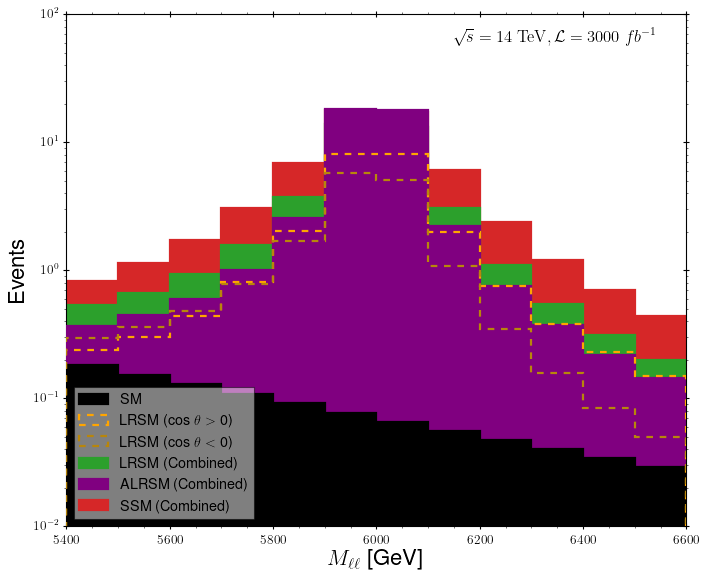

In [34]:
pyplot.rcParams['figure.figsize'] = (10.0, 8.0)
#fig.suptitle(r'No $y_{\ell \ell}$ Cut', fontsize=40)

BinNumber = 12
BinFirst  = 5400.
BinLast   = 6600.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

#bins = [5400.0, 5900.0, 6000.0, 6100.0, 6600.0]     
    
    
binlabel = []
i=0
for i in range(len(bins)-1):
    binlabel.append((bins[i]+bins[i+1])/2.)
    
    
fig, ax1 = plt.subplots()
fig.set_facecolor('white')
#plt.title(r"$E_6 - \psi$ Model", fontsize=20)
plt.hist(binlabel,bins=bins,
             label=r'SM', histtype="stepfilled", rwidth=1.0,
             weights=NumofEvents_LepPos_SM+NumofEvents_LepNeg_SM, facecolor="black",
             color=None, edgecolor='black', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=5)
plt.hist(binlabel,bins=bins,
             label=r'LRSM (cos $\theta > $ 0)', histtype="step", rwidth=1.0,
             weights=NumofEvents_LepPos_LRSM, facecolor="orange",
             color=None, edgecolor='orange', linewidth=2, linestyle="dashed",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=7)
plt.hist(binlabel,bins=bins,
             label=r'LRSM (cos $\theta < $ 0)', histtype="step", rwidth=1.0,
             weights=NumofEvents_LepNeg_LRSM, facecolor="darkgoldenrod",
             color=None, edgecolor='darkgoldenrod', linewidth=2, linestyle="dashed",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=8)
plt.hist(binlabel,bins=bins,
             label=r'LRSM (Combined)', histtype="stepfilled", rwidth=1.0,
             weights=NumofEvents_LepPos_LRSM+NumofEvents_LepNeg_LRSM, facecolor="tab:green",
             color=None, edgecolor='tab:green', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=2)

plt.hist(binlabel,bins=bins,
             label=r'ALRSM (Combined)', histtype="stepfilled", rwidth=1.0,
             weights=NumofEvents_LepPos_ALRSM+NumofEvents_LepNeg_ALRSM, facecolor="purple",
             color=None, edgecolor='purple', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=3)

plt.hist(binlabel,bins=bins,
             label=r'SSM (Combined)', histtype="stepfilled", rwidth=1.0,
             weights=NumofEvents_LepPos_SSM+NumofEvents_LepNeg_SSM, facecolor="tab:red",
             color=None, edgecolor='tab:red', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=1)


plt.xlabel(r' $M_{\ell \ell}$ [GeV]' , fontsize=20)
plt.ylabel('Events' , fontsize=20)
#plt.xscale('log')
plt.yscale('log')

ax1.text(6150, 60, r"$\displaystyle \sqrt{s} = 14 {\rm\ TeV}, \mathcal{L} = 3000\ fb^{-1}$", size=15)


leg = ax1.legend(loc='lower left',fontsize=13) #,ncol=2)#,framealpha=.5)#.get_lines().set_linewidth(0.)
leg.get_frame().set_alpha(0.5)
#leg.get_frame().set_linewidth(0.0)
leg.set_zorder(100)
ax1.set_xlim([min(bins),max(bins)])
#ax1.set_ylim([1e-4,1e1])
ax1.tick_params(axis="x", direction="inout", length=6, width=1, color="black",zorder=100)
ax1.tick_params(axis="y", direction="inout", length=6, width=1, color="black",zorder=100)
ax1.tick_params(which="minor", axis="x", direction="out")
ax1.tick_params(which="minor", axis="y", direction="out")

#fig.savefig('/Users/oozdal/Dropbox/WpZp_Project/Results/Ozer/Mll_LRSMvsALRSMvsSSM.png') 
plt.show()

In [144]:
Tot_NumofEvents_SM = NumofEvents_LepPos_SM+NumofEvents_LepNeg_SM
Tot_NumofEvents_SSM = NumofEvents_LepPos_SSM+NumofEvents_LepNeg_SSM
Tot_NumofEvents_LRSM = NumofEvents_LepPos_LRSM+NumofEvents_LepNeg_LRSM
Tot_NumofEvents_ALRSM = NumofEvents_LepPos_ALRSM+NumofEvents_LepNeg_ALRSM

#JSD_SMvsLRSM  = jensen_shannon_distance(Tot_NumofEvents_LRSM, Tot_NumofEvents_SM)
#JSD_SMvsALRSM  = jensen_shannon_distance(Tot_NumofEvents_ALRSM, Tot_NumofEvents_SM)
#JSD_LRSMvsALRSM = jensen_shannon_distance(Tot_NumofEvents_LRSM, Tot_NumofEvents_ALRSM)

JSD_SMvsLRSM    = distance.jensenshannon(Tot_NumofEvents_SM, Tot_NumofEvents_LRSM)
JSD_SMvsALRSM   = distance.jensenshannon(Tot_NumofEvents_SM, Tot_NumofEvents_ALRSM)
JSD_LRSMvsALRSM = distance.jensenshannon(Tot_NumofEvents_LRSM, Tot_NumofEvents_ALRSM)

print("JSD(SM vs LRSM:)", JSD_SMvsLRSM)
print("JSD(SM vs ALRSM:)", JSD_SMvsALRSM)
print("JSD(LRSM vs ALRSM:)", JSD_LRSMvsALRSM)

KLD_SMvsLRSM    = KLD(Tot_NumofEvents_SM, Tot_NumofEvents_LRSM)
KLD_SMvsALRSM   = KLD(Tot_NumofEvents_SM, Tot_NumofEvents_ALRSM)
KLD_LRSMvsALRSM = KLD(Tot_NumofEvents_LRSM, Tot_NumofEvents_ALRSM)

KLD_LRSMvsSSM   = KLD(Tot_NumofEvents_SSM, Tot_NumofEvents_LRSM)
KLD_ALRSMvsSSM  = KLD(Tot_NumofEvents_SSM, Tot_NumofEvents_ALRSM)

('JSD(SM vs LRSM:)', 0.41052548520380233)
('JSD(SM vs ALRSM:)', 0.498044840842838)
('JSD(LRSM vs ALRSM:)', 0.10145183384571407)


In [145]:
sig_AFB_LRSM  = []
sig_AFB_ALRSM = []
sig_AFB_SSM   = []
sig_AFB_SM    = []


for element in AFB_LRSM:
    sig_AFB_LRSM.append(sigmoid(element))

for element in AFB_ALRSM:
    sig_AFB_ALRSM.append(sigmoid(element))
    
for element in AFB_SSM:
    sig_AFB_SSM.append(sigmoid(element))
    

print(sig_AFB_SSM)    
 
print(sig_AFB_ALRSM)    
    
KLD_LRSMvsALRSM   = KLD( sig_AFB_LRSM,  sig_AFB_ALRSM )
KLD_LRSMvsSSM     = KLD( sig_AFB_LRSM,  sig_AFB_SSM )
KLD_ALRSMvsSSM    = KLD( sig_AFB_ALRSM, sig_AFB_SSM )

[0.4721374305254961, 0.5109702711586128, 0.524620384369237, 0.5489758364176632]
[0.4919035761224581, 0.5312770995280919, 0.5461070594276333, 0.5830548710015246]


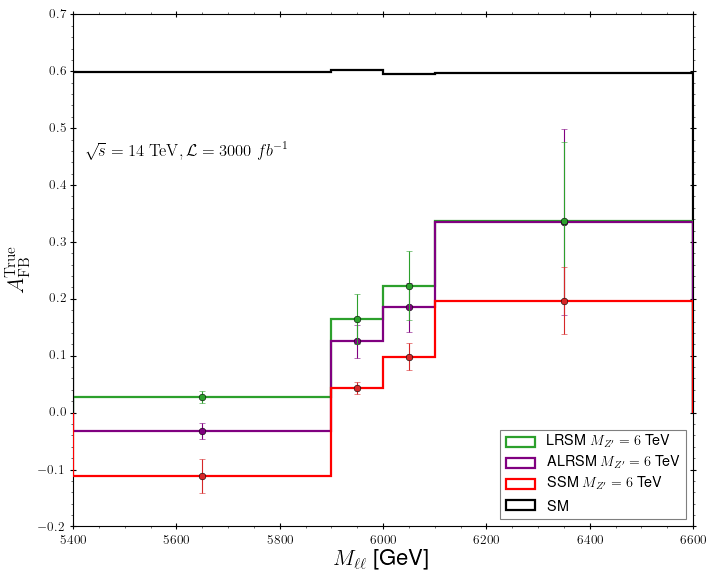

In [153]:
pyplot.rcParams['figure.figsize'] = (10.0, 8.0)
#fig.suptitle(r'No $y_{\ell \ell}$ Cut', fontsize=40)

BinNumber = 12
BinFirst  = 5400.
BinLast   = 6600.

StepSize = (BinLast - BinFirst)/BinNumber
bins = []
bins.append(BinFirst)

for i in range(BinNumber): 
    BinFirst = BinFirst + StepSize
    bins.append(BinFirst)

bins = [5400.0, 5900.0, 6000.0, 6100.0, 6600.0]        
    
binlabel = []
i=0
for i in range(len(bins)-1):
    binlabel.append((bins[i]+bins[i+1])/2.)


#fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [4, 1]})
fig, ax1 = plt.subplots()
fig.set_facecolor('white')
#plt.title(r"$E_6 - \eta$ Model", fontsize=20)
ax1.hist(binlabel,bins=bins,
             label=r"LRSM $M_{Z^\prime} = 6$ TeV", histtype="step", rwidth=1.0,
             weights=AFB_LRSM, facecolor="tab:green",
             color=None, edgecolor='tab:green', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=2)
ax1.hist(binlabel,bins=bins,
             label=r"ALRSM $M_{Z^\prime} = 6$ TeV", histtype="step", rwidth=1.0,
             weights=AFB_ALRSM, facecolor="purple",
             color=None, edgecolor='purple', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=3)

ax1.hist(binlabel,bins=bins,
             label=r"SSM $M_{Z^\prime} = 6$ TeV", histtype="step", rwidth=1.0,
             weights=AFB_SSM, facecolor="purple",
             color=None, edgecolor='red', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=4)

ax1.hist(binlabel,bins=bins,
             label=r"SM", histtype="step", rwidth=1.0,
             weights=AFB_SM, facecolor="black",
             color=None, edgecolor='black', linewidth=2, linestyle="solid",
             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=1)


#ax1.errorbar(binlabel, AFB_SM, yerr=AFB_SM*unc(AFB_SM,NumofEvents_LepPos_SM+NumofEvents_LepNeg_SM), linestyle='None', marker='o')
ax1.errorbar(binlabel, AFB_SSM, yerr=AFB_SSM*unc(AFB_SSM,(NumofEvents_LepPos_SSM+NumofEvents_LepNeg_SSM)), 
             linestyle='None', marker='o', color='tab:red', zorder = 6)
ax1.errorbar(binlabel, AFB_LRSM, yerr=AFB_LRSM*unc(AFB_LRSM,(NumofEvents_LepPos_LRSM+NumofEvents_LepNeg_LRSM)), 
             linestyle='None', marker='o', color='tab:green', zorder = 5)
ax1.errorbar(binlabel, AFB_ALRSM, yerr=AFB_ALRSM*unc(AFB_ALRSM,(NumofEvents_LepPos_ALRSM+NumofEvents_LepNeg_ALRSM)), 
             linestyle='None', marker='o', color='purple', zorder = 4)

#ax1.set_xlabel(r' $M_{\ell \ell}$ [GeV]' , fontsize=20)
ax1.set_ylabel(r'$A_{\rm FB}^{\rm True}$' , fontsize=20)
#ax1.set_yscale('log')

ax1.text(5425, 0.45, r"$\displaystyle \sqrt{s} = 14 {\rm\ TeV}, \mathcal{L} = 3000\ fb^{-1}$", size=15)
#ax1.text(5800, -0.5, r"$\displaystyle JSD_{\rm SM-LRSM}$ ="+"{:.6}".format(JSD_SMvsLRSM), size=15)
#ax1.text(5800, -0.6, r"$\displaystyle JSD_{\rm SM-ALRSM}$ ="+"{:.6}".format(JSD_SMvsALRSM), size=15)
#ax1.text(5800, -0.7, r"$\displaystyle JSD_{\rm LRSM-ALRSM}$ ="+"{:.6}".format(JSD_LRSMvsALRSM), size=15)


leg = ax1.legend(loc='lower right',fontsize=13) #,ncol=2)#,framealpha=.5)#.get_lines().set_linewidth(0.)
leg.get_frame().set_alpha(0.5)
#leg.get_frame().set_linewidth(0.0)
leg.set_zorder(100)
ax1.set_xlim([min(bins),max(bins)])
ax1.set_ylim([-0.2,0.7])
ax1.tick_params(axis="x", direction="inout", length=6, width=1, color="black",zorder=100)
ax1.tick_params(axis="y", direction="inout", length=6, width=1, color="black",zorder=100)
ax1.tick_params(which="minor", axis="x", direction="out")
ax1.tick_params(which="minor", axis="y", direction="out")

#ax2.hist(binlabel,bins=bins,
#             label=r"$\displaystyle {\rm\ LRSM\ and\ ALRSM} $ ", histtype="step", rwidth=1.0,
#             weights=KLD_LRSMvsALRSM, facecolor="tab:green",
#             color=None, edgecolor='tab:green', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=1)

#ax2.hist(binlabel,bins=bins,
#             label=r"$\displaystyle {\rm\ LRSM\ and\ SSM} $ ", histtype="step", rwidth=1.0,
#             weights=KLD_LRSMvsSSM, facecolor="tab:red",
#             color=None, edgecolor='tab:red', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=2)

#ax2.hist(binlabel,bins=bins,
#             label=r"$\displaystyle {\rm\ ALRSM\ and\ SSM} $ ", histtype="step", rwidth=1.0,
#             weights=KLD_ALRSMvsSSM, facecolor="tab:blue",
#             color=None, edgecolor='tab:blue', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=3)


#ax2.hist(binlabel,bins=bins,
#             label=r'LRSM (Combined)', histtype="step", rwidth=1.0,
#             weights=sig(AFB_SM, AFB_LRSM, (NumofEvents_LepPos_SM+NumofEvents_LepNeg_SM), (NumofEvents_LepPos_LRSM+NumofEvents_LepNeg_LRSM)), facecolor="tab:green",
#             color=None, edgecolor='tab:green', linewidth=2, linestyle="solid",
#             bottom=None, cumulative=False, density=False, align="mid", orientation="vertical",zorder=1)

#ax2.errorbar(binlabel, sig(AFB_SM, AFB_LRSM, (NumofEvents_LepPos_SM+NumofEvents_LepNeg_SM), (NumofEvents_LepPos_LRSM+NumofEvents_LepNeg_LRSM)), yerr=AFB_LRSM*unc(AFB_LRSM,(NumofEvents_LepPos_LRSM+NumofEvents_LepNeg_LRSM)), linestyle='None', marker='o', color='purple')

#ax2.set_ylim([0,1.5])


ax1.set_xlabel(r' $M_{\ell \ell}$ [GeV]' , fontsize=20)
#ax2.set_xlabel(r' $M_{\ell \ell}$ [GeV]' , fontsize=20)
#ax2.set_ylabel(r'${\rm KLD}$' , fontsize=20)

#plt.yscale('log')

#leg = ax2.legend(loc='lower center',fontsize=10)

#fig.tight_layout()

fig.savefig('/Users/oozdal/Dropbox/WpZp_Project/Results/Ozer/AFB_LRSMvsALRSMvsSSM.png')
plt.show()